<center>
<h style="line-height: 0.5;">

# Applying Machine Learning to Gravitational Lens Modeling
#### <ins>Research Advisor</ins>: Professor Charles Keeton
#### <ins>Research Assistant</ins>: Satyajit Gade

</h>
</center>

In [ ]:
# imports all the modules needed
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import arviz
import Scripts.pygravlens as gl
from astropy.cosmology import Planck18 as cosmo

from matplotlib.patches import Arc
from pathlib import Path

### Generating Corner/Scatter Plots

In [2]:
# Dr. Keeton's code:

def visualize_data(dataarray,colorindex,labels,title):
    f,ax = plt.subplots(4,4,figsize=(16,16))
    f.suptitle(title,fontsize=16)
    for i1 in range(4):
        for i2 in range(4):
            if i2<=i1:
                ax[i1][i2].scatter(dataarray[:,i2],dataarray[:,i1+1],c=dataarray[:,colorindex],marker='o')
                ax[i1][i2].set_xlabel(labels[i2], fontsize=14)
                ax[i1][i2].set_ylabel(labels[i1+1], fontsize=14)
            else:
                ax[i1][i2].axis('off')
    ax[0][1].text(0.5,0.5,'color: '+labels[colorindex],ha='center',va='center', fontsize=14)
    f.tight_layout()
    plt.show()

In [3]:
# Amarel Output Folder
data_path = Path("CombinedArrays")

### Shear Only

In [4]:
vals_shear = np.load(data_path / 'valShear.npy', allow_pickle = True)

In [42]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_shear)):
    print('Here is the image array: \n', vals_shear[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_shear[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_shear[i]["time"], '\n')
    ---
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase = []
for i in range(len(vals_shear)):
    size = len(vals_shear[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase.append(neither)

typeLens = dict(single = single, double = double, quad = quad)

print("The index array (containing the first 20 elements only) for a single image producing mock lens is: ", typeLens["single"][:20],'\n')
print("The index array (containing the first 20 elements only) for a double image producing mock lens is: ", typeLens["double"][:20],'\n')
print("The index array (containing the first 20 elements only) for a quad image producing mock lens is: ", typeLens["quad"][:20],'\n')

# truncating output:
max_prints = 5
count = 0

for j in weirdCase:
    sz = len(j)
    if sz != 0 and count < max_prints:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')
        
        count += 1
print('Output Truncated')

The index array (containing the first 20 elements only) for a single image producing mock lens is:  [8, 186, 294, 695, 1414, 1845, 2126, 2180, 2676, 2868, 3450, 3608, 4086, 4380, 4502, 4668, 4730, 5475, 5727, 6077] 

The index array (containing the first 20 elements only) for a double image producing mock lens is:  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 

The index array (containing the first 20 elements only) for a quad image producing mock lens is:  [146, 234, 454, 1128, 1179, 1286, 1301, 1510, 1783, 2034, 2053, 2107, 2588, 2628, 2633, 2824, 2958, 2998, 3039, 3090] 

The index for neither single, double, or quad is:  1238 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------
The index for neither single, double, or quad is:  1687 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens------------

#### Visualizing Shear-Only data

Text(0.5, 1.0, 'Graph of Image Positions (SIS+shear)')

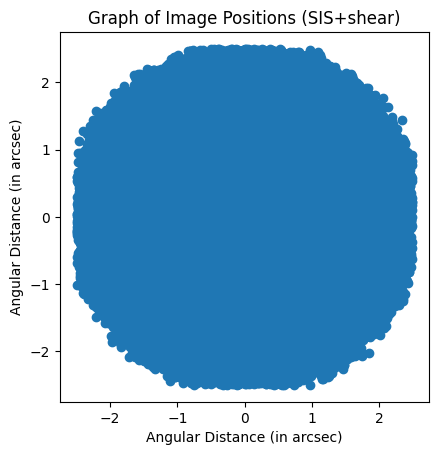

In [6]:
imX_shear = [];
imY_shear = [];


for i in typeLens["single"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imY_shear.append(elem[0][1])

for i in typeLens["double"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imX_shear.append(elem[1][0])
    imY_shear.append(elem[0][1])
    imY_shear.append(elem[1][1])
    
for i in typeLens["quad"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imX_shear.append(elem[1][0])
    imX_shear.append(elem[2][0])
    imX_shear.append(elem[3][0])
    
    imY_shear.append(elem[0][1])
    imY_shear.append(elem[1][1])
    imY_shear.append(elem[2][1])
    imY_shear.append(elem[3][1])

newX_shear = np.array(imX_shear)
newY_shear = np.array(imY_shear)

plt.scatter(newX_shear, newY_shear)

betaOne_shear = [vals_shear[i]["betaOne"] for i in range(len(vals_shear))]
betaTwo_shear = [vals_shear[i]["betaTwo"] for i in range(len(vals_shear))]

plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIS+shear)')


Text(0.5, 1.0, 'Graph of Source Positions (SIS+shear)')

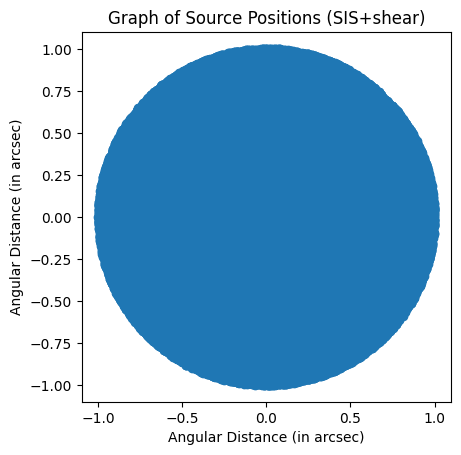

In [7]:
plt.scatter(betaOne_shear,betaTwo_shear)
plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIS+shear)')

Text(0.5, 1.0, 'Graph of Source and Image Positions Overlayed (SIS+shear)')

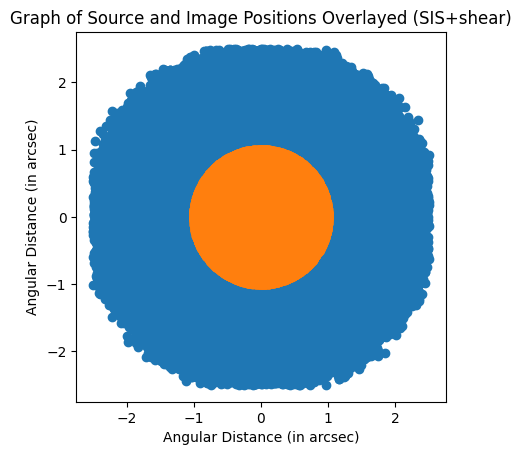

In [8]:
plt.scatter(newX_shear, newY_shear)
plt.scatter(betaOne_shear,betaTwo_shear)
plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source and Image Positions Overlayed (SIS+shear)')

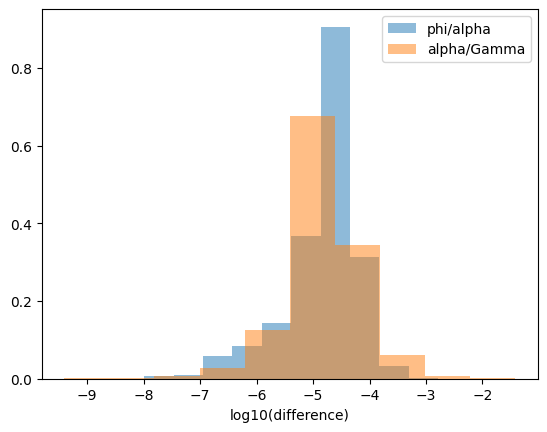

c:\Users\satya\Documents\GravLensing\pygravlens.py:1571: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


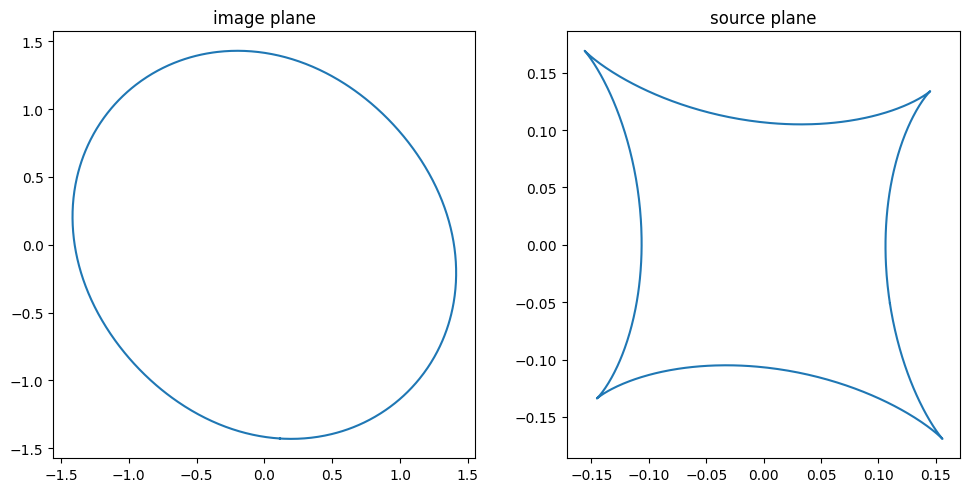

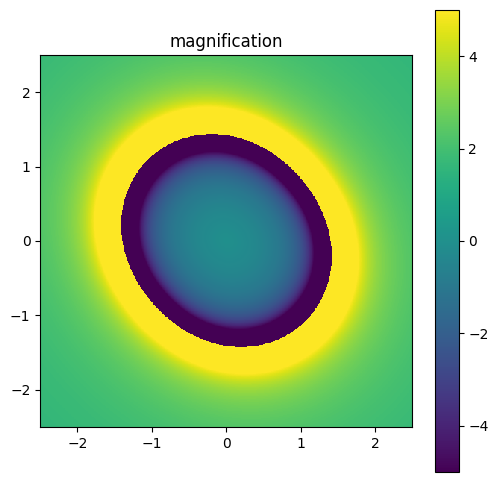

c:\Users\satya\Documents\GravLensing\pygravlens.py:1641: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


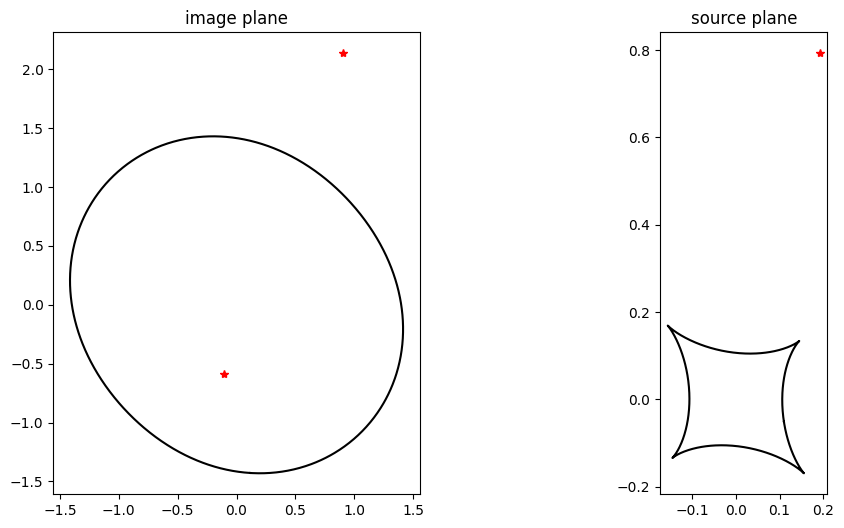

In [9]:
# Arbitrary point chosen from above list of points to graph.

betaOne = betaOne_shear[26]
betaTwo = betaTwo_shear[26] # choose
betaArray= [betaOne, betaTwo] 

eins = [vals_shear[i]["einrad"] for i in range(len(vals_shear))]

# array of randomized shear vals between 0 and 0.1, same size as eins array
gc = [vals_shear[i]["gammc"] for i in range(len(vals_shear))]
gs = [vals_shear[i]["gamms"] for i in range(len(vals_shear))]
 
ellip = 0.0

xtmp_elpow = np.random.uniform(low=-2,high=2,size=(1000,2))

plane_elpow = gl.lensplane('ellpow',[0.0,0.0,1.0,eins[26],ellip,ellip],gammac=gc[26],gammas=gs[26])
plane_elpow.check(xtmp_elpow)

model_elpow = gl.lensmodel([plane_elpow])
model_elpow.tile()
model_elpow.plotcrit()
model_elpow.plotmag()

imgarr,muarr,tarr = model_elpow.findimg(betaArray)
model_elpow.plot(src=betaArray)



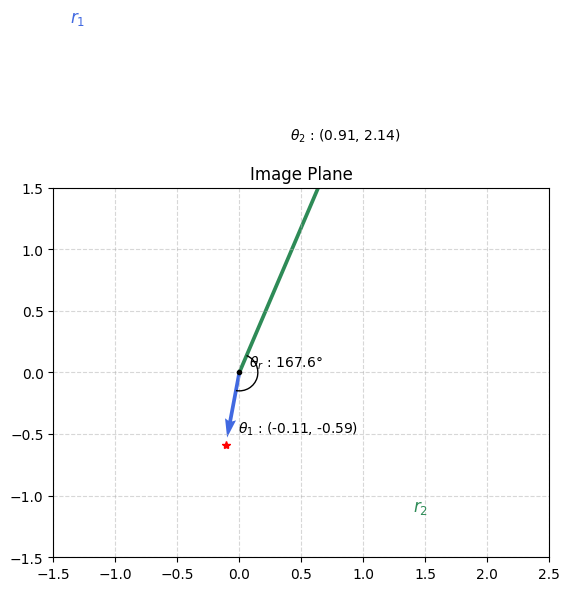

In [10]:
fig2,ax2 = plt.subplots()
x_lim = ax2.set_xlim(-1.5,2.5)
y_lim = ax2.set_ylim(-1.5,1.5)

r_im1 = np.array(imgarr[0])
r_im2 = np.array(imgarr[1])
v_orig = np.array(imgarr)

# reducing the size of vectors for clarity of eyes
v_orig[0] = 0.98*v_orig[0]
v_orig[1] = 0.9*v_orig[1]

V = v_orig.T
origin = np.array([[0,0],[0,0]]).T

cos_theta = np.dot(r_im1, r_im2) / (np.linalg.norm(r_im1) * np.linalg.norm(r_im2))
theta_rad = np.arccos(np.clip(cos_theta, -1, 1))  # Clip to avoid numerical errors
theta_deg = np.degrees(theta_rad)  # Convert to degrees

ax2.plot(0, 0, marker='.',color='black')
ax2.plot(r_im2[0], r_im2[1], marker='*',color='red', label=f'Image 1: ({r_im2[0]:.2f}, {r_im2[1]:.2f})')
ax2.plot(r_im1[0], r_im1[1], marker='*',color='red', label=f'Image 2: ({r_im1[0]:.2f}, {r_im1[1]:.2f})')


# Get vector angles for proper arc placement
angle1 = np.degrees(np.arctan2(r_im1[1], r_im1[0]))
angle2 = np.degrees(np.arctan2(r_im2[1], r_im2[0]))

# Add angle arc (radius = min vector length * 0.5)
radius = 0.25 * min(np.linalg.norm(r_im1), np.linalg.norm(r_im2))  # Reduced radius
arc = Arc((0, 0), 2*radius, 2*radius, angle=0,
          theta1=min(angle1, angle2), theta2=max(angle1, angle2),
          color='black', lw=1, zorder=3)
ax2.add_patch(arc)


# Add coordinate labels 
plt.text(r_im1[0]-0.5, r_im1[1] - 0.25, r'$\theta_2$ : ' + f'({r_im1[0]:.2f}, {r_im1[1]:.2f})', fontsize=10)
plt.text(r_im2[0] + 0.1, r_im2[1]+0.1, r'$\theta_1$ : ' + f'({r_im2[0]:.2f}, {r_im2[1]:.2f})', fontsize=10)

mid_angle = (angle1 + angle2)/2
label_x = 0.5 * radius * np.cos(np.radians(mid_angle))
label_y = 0.5 * radius * np.sin(np.radians(mid_angle))
ax2.text(label_x + 0.3, label_y+0.1, r'$\theta_r$ : ' + f'{theta_deg:.1f}°', 
        color='black', fontsize=10, ha='center', va='center')
# vector plot
ax2.quiver(origin[0], origin[1], V[0], V[1], color=['seagreen', 'royalblue'], angles='xy', scale_units='xy', scale=1)

ax2.text(v_orig[0][0] - 2.25, v_orig[0][1] + 0.75, r'$r_1$',size=12,color='royalblue')
ax2.text(v_orig[1][0] + 1.5, v_orig[1][1] - 0.60, r'$r_2$',size=12,color='seagreen')

#labels
ax2.grid(linestyle='--', alpha=0.5)
#ax2.legend(loc='best')  # Show legend with coordinates
plt.title("Image Plane")
# model_elpow.plot(src=betaArray)
plt.show()


In [11]:
print("src: ", betaArray, "\n")
print("image: ", imgarr, "\n")
print("mag: ", muarr, "\n")
print("time del: ", tarr, "\n")

src:  [np.float64(0.19242215270925547), np.float64(0.7926176928105165)] 

image:  [[ 0.9059098   2.13590824]
 [-0.10976482 -0.58715217]] 

mag:  [ 2.37236777 -0.77096011] 

time del:  [0.         2.38186875] 



In [13]:
def unit_vector(vector):
    # Returns the unit vector of the vector.  
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'
    
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#### Corner Plots for SIS+shear

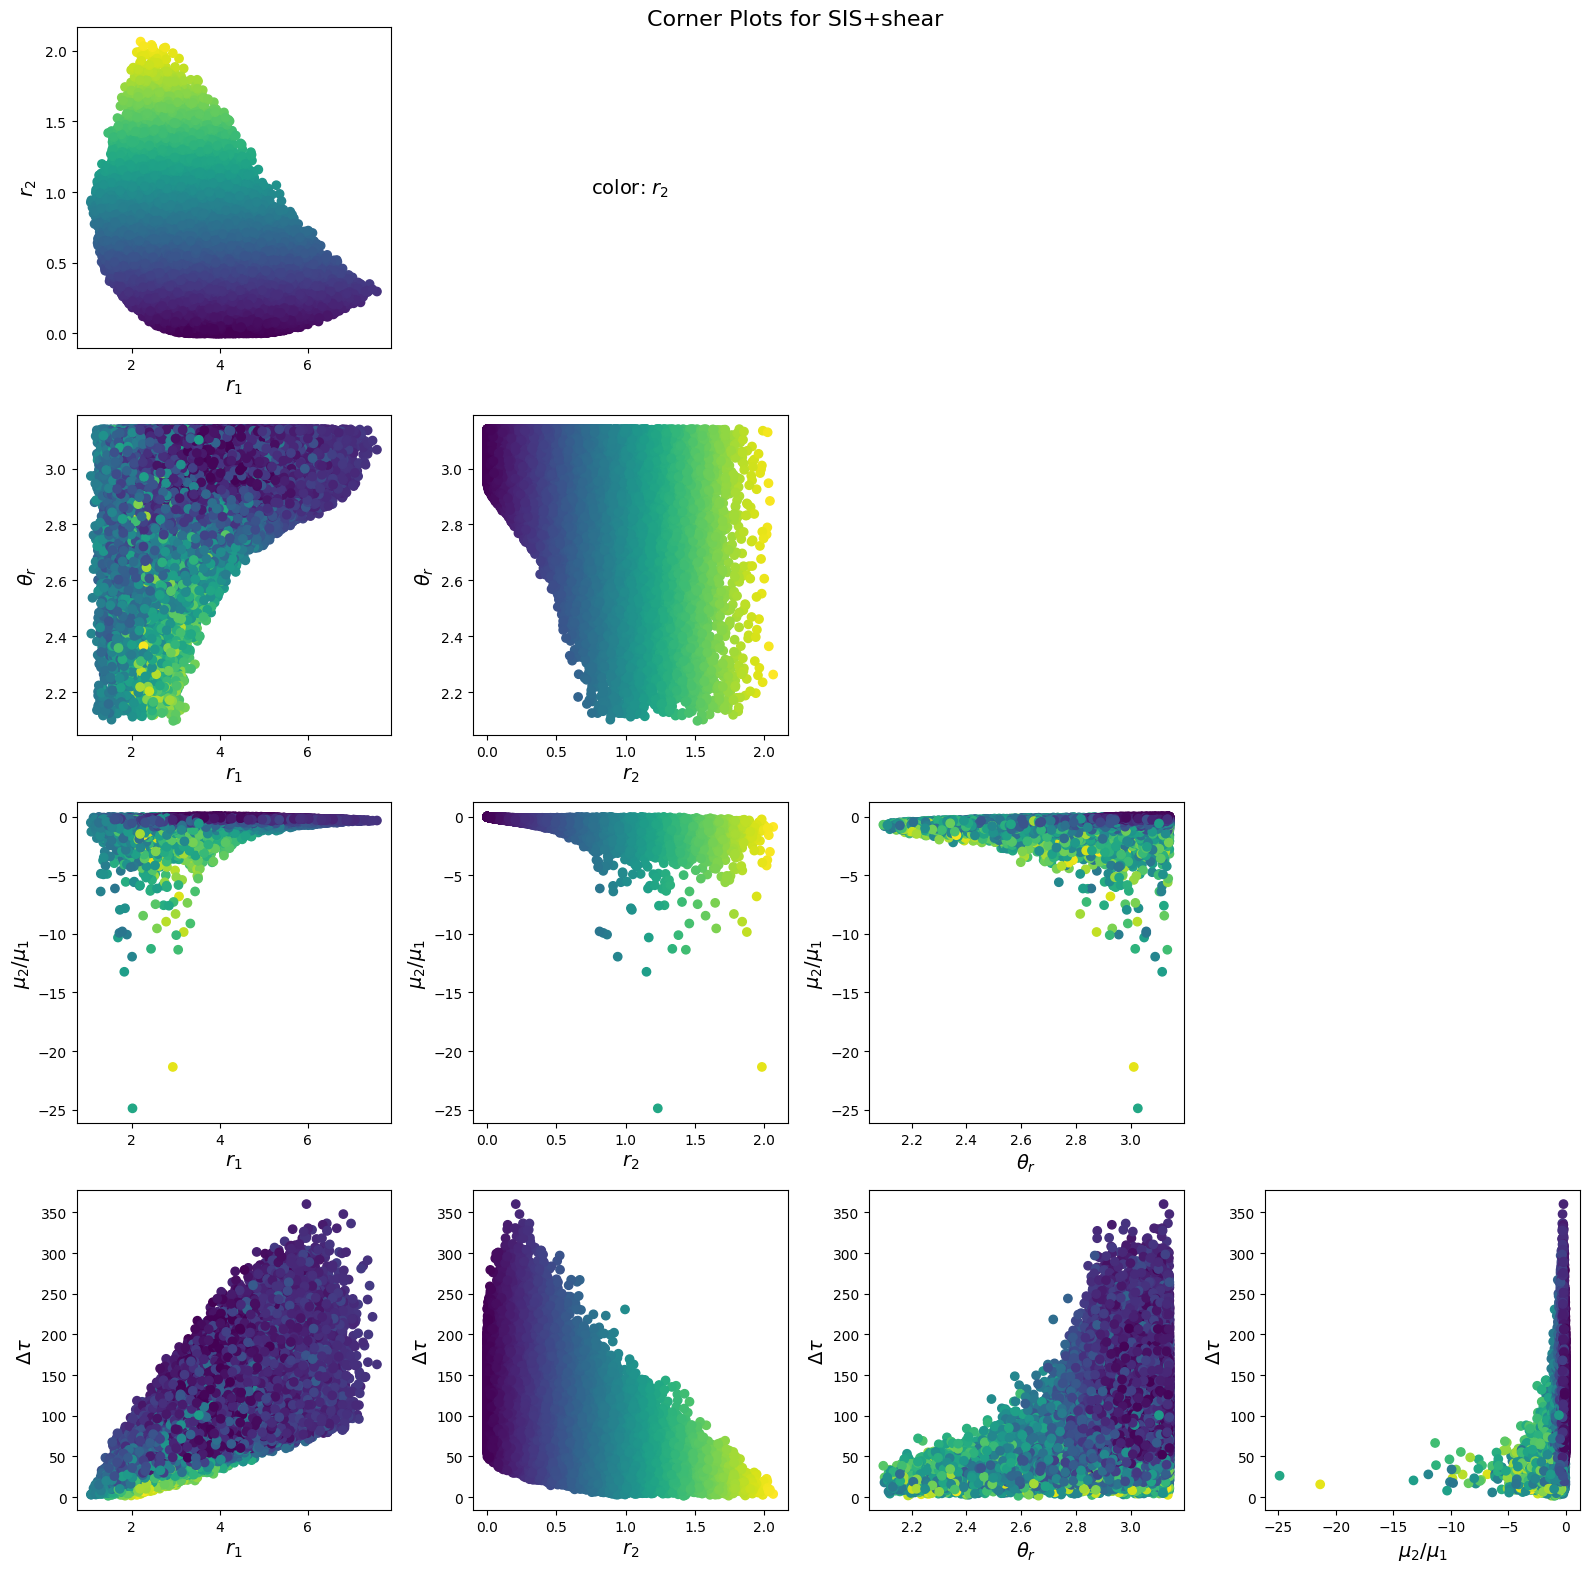

In [14]:
r_1 = [];
r_2 = [];

for i in typeLens["double"]:
    elem = vals_shear[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_shear[i]["mu"][0] for i in typeLens["double"]])
mu_2 = np.array([vals_shear[i]["mu"][1] for i in typeLens["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_shear[i]["time"][0].value for i in typeLens["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_shear[i]["time"][1].value for i in typeLens["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_shear[i]["zLens"] for i in typeLens["double"]])
z_s = np.array([vals_shear[i]["zSrc"] for i in typeLens["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, tau)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 1, ['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$',r'$\Delta\tau$'], 'Corner Plots for SIS+shear') 


##### Shear Only Image Statistics

In [15]:
## Shear ONLY
### percentage of Singles, Doubles, and Quads 

single_len = len(typeLens["single"]);
double_len = len(typeLens["double"]);
quad_len = len(typeLens["quad"]);
total_len = single_len + double_len + quad_len

percent_single = (single_len/total_len)*100
percent_double = (double_len/total_len)*100
percent_quad = (quad_len/total_len)*100

print(percent_single)
print(percent_double)
print(percent_quad)
print(total_len)

0.32634265979278243
98.9128585014265
0.7607988387807197
99895


In [16]:
# rare cases lenses
filtered_array = [d for d in weirdCase if d!= {}]
rare_case_len = len(filtered_array)
total_len_with_rare = total_len + rare_case_len

percent_single_accounting_rare = (single_len/total_len_with_rare)*100
percent_double_accounting_rare = (double_len/total_len_with_rare)*100
percent_quad_accounting_rare = (quad_len/total_len_with_rare)*100
percent_rare_accounting_rare = (rare_case_len/total_len_with_rare)*100

print("The percentage for Single Lenses: ", percent_single_accounting_rare, "%")
print("The percentage for Double Lenses: ", percent_double_accounting_rare, "%")
print("The percentage for Quad Lenses: ", percent_quad_accounting_rare, "%")
print("The percentage for 'Rare' Lenses: ", percent_rare_accounting_rare, "%")

The percentage for Single Lenses:  0.326 %
The percentage for Double Lenses:  98.809 %
The percentage for Quad Lenses:  0.76 %
The percentage for 'Rare' Lenses:  0.105 %


In [17]:
### Confirming math:
total_percent = percent_single_accounting_rare + percent_double_accounting_rare + percent_quad_accounting_rare + percent_rare_accounting_rare
print(total_percent)

100.0


### Ellipticity Only

In [18]:
vals_ellip = np.load(data_path / 'valEllip.npy', allow_pickle = True)

In [43]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_ellip)):
    print('Here is the image array: \n', vals_ellip[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_ellip[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_ellip[i]["time"], '\n')
    --
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''
    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase_ellip = []
for i in range(len(vals_ellip)):
    size = len(vals_ellip[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase_ellip.append(neither)

typeLens_ellip = dict(single = single, double = double, quad = quad)

print("The index array (containing the first 20 elements only) for a single image producing mock lens is: ", typeLens_ellip["single"][:20],'\n')
print("The index array (containing the first 20 elements only) for a double image producing mock lens is: ", typeLens_ellip["double"][:20],'\n')
print("The index array (containing the first 20 elements only) for a quad image producing mock lens is: ", typeLens_ellip["quad"][:20],'\n')

# truncating output:
max_prints = 5
count = 0

for j in weirdCase_ellip:
    sz = len(j)
    if sz != 0 and count < max_prints:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')
        
        count += 1
print('Output Truncated')
        

The index array (containing the first 20 elements only) for a single image producing mock lens is:  [7, 12, 49, 66, 84, 133, 156, 174, 179, 186, 208, 245, 294, 318, 378, 386, 407, 409, 412, 419] 

The index array (containing the first 20 elements only) for a double image producing mock lens is:  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

The index array (containing the first 20 elements only) for a quad image producing mock lens is:  [23, 24, 57, 65, 81, 146, 163, 192, 234, 308, 313, 323, 326, 333, 366, 391, 395, 400, 465, 488] 

The index for neither single, double, or quad is:  3786 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------
The index for neither single, double, or quad is:  5132 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------
The index for neither sin

#### Visualizing Ellipticity-Only Data

Text(0.5, 1.0, 'Graph of Image Positions (SIE)')

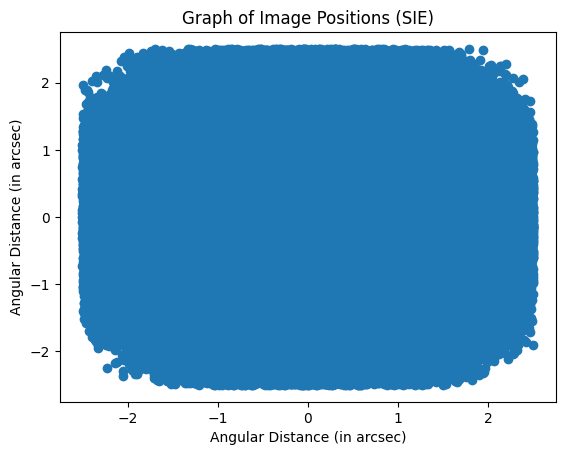

In [20]:
imX_ellip = [];
imY_ellip = [];

for i in typeLens_ellip["single"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imY_ellip.append(elem[0][1])

for i in typeLens_ellip["double"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imX_ellip.append(elem[1][0])
    imY_ellip.append(elem[0][1])
    imY_ellip.append(elem[1][1])
    
for i in typeLens_ellip["quad"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imX_ellip.append(elem[1][0])
    imX_ellip.append(elem[2][0])
    imX_ellip.append(elem[3][0])
    
    imY_ellip.append(elem[0][1])
    imY_ellip.append(elem[1][1])
    imY_ellip.append(elem[2][1])
    imY_ellip.append(elem[3][1])
    

newX_ellip = np.array(imX_ellip)
newY_ellip = np.array(imY_ellip)

plt.scatter(newX_ellip, newY_ellip)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIE)')


Text(0.5, 1.0, 'Graph of Source Positions (SIE)')

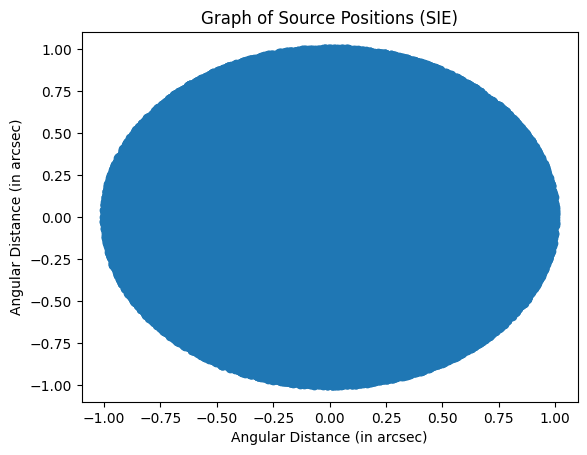

In [21]:
betaOne_ellip = [vals_ellip[i]["betaOne"] for i in range(len(vals_ellip))]
betaTwo_ellip = [vals_ellip[i]["betaTwo"] for i in range(len(vals_ellip))]
plt.scatter(betaOne_ellip,betaTwo_ellip)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIE)')

#### Corner Plots for SIE

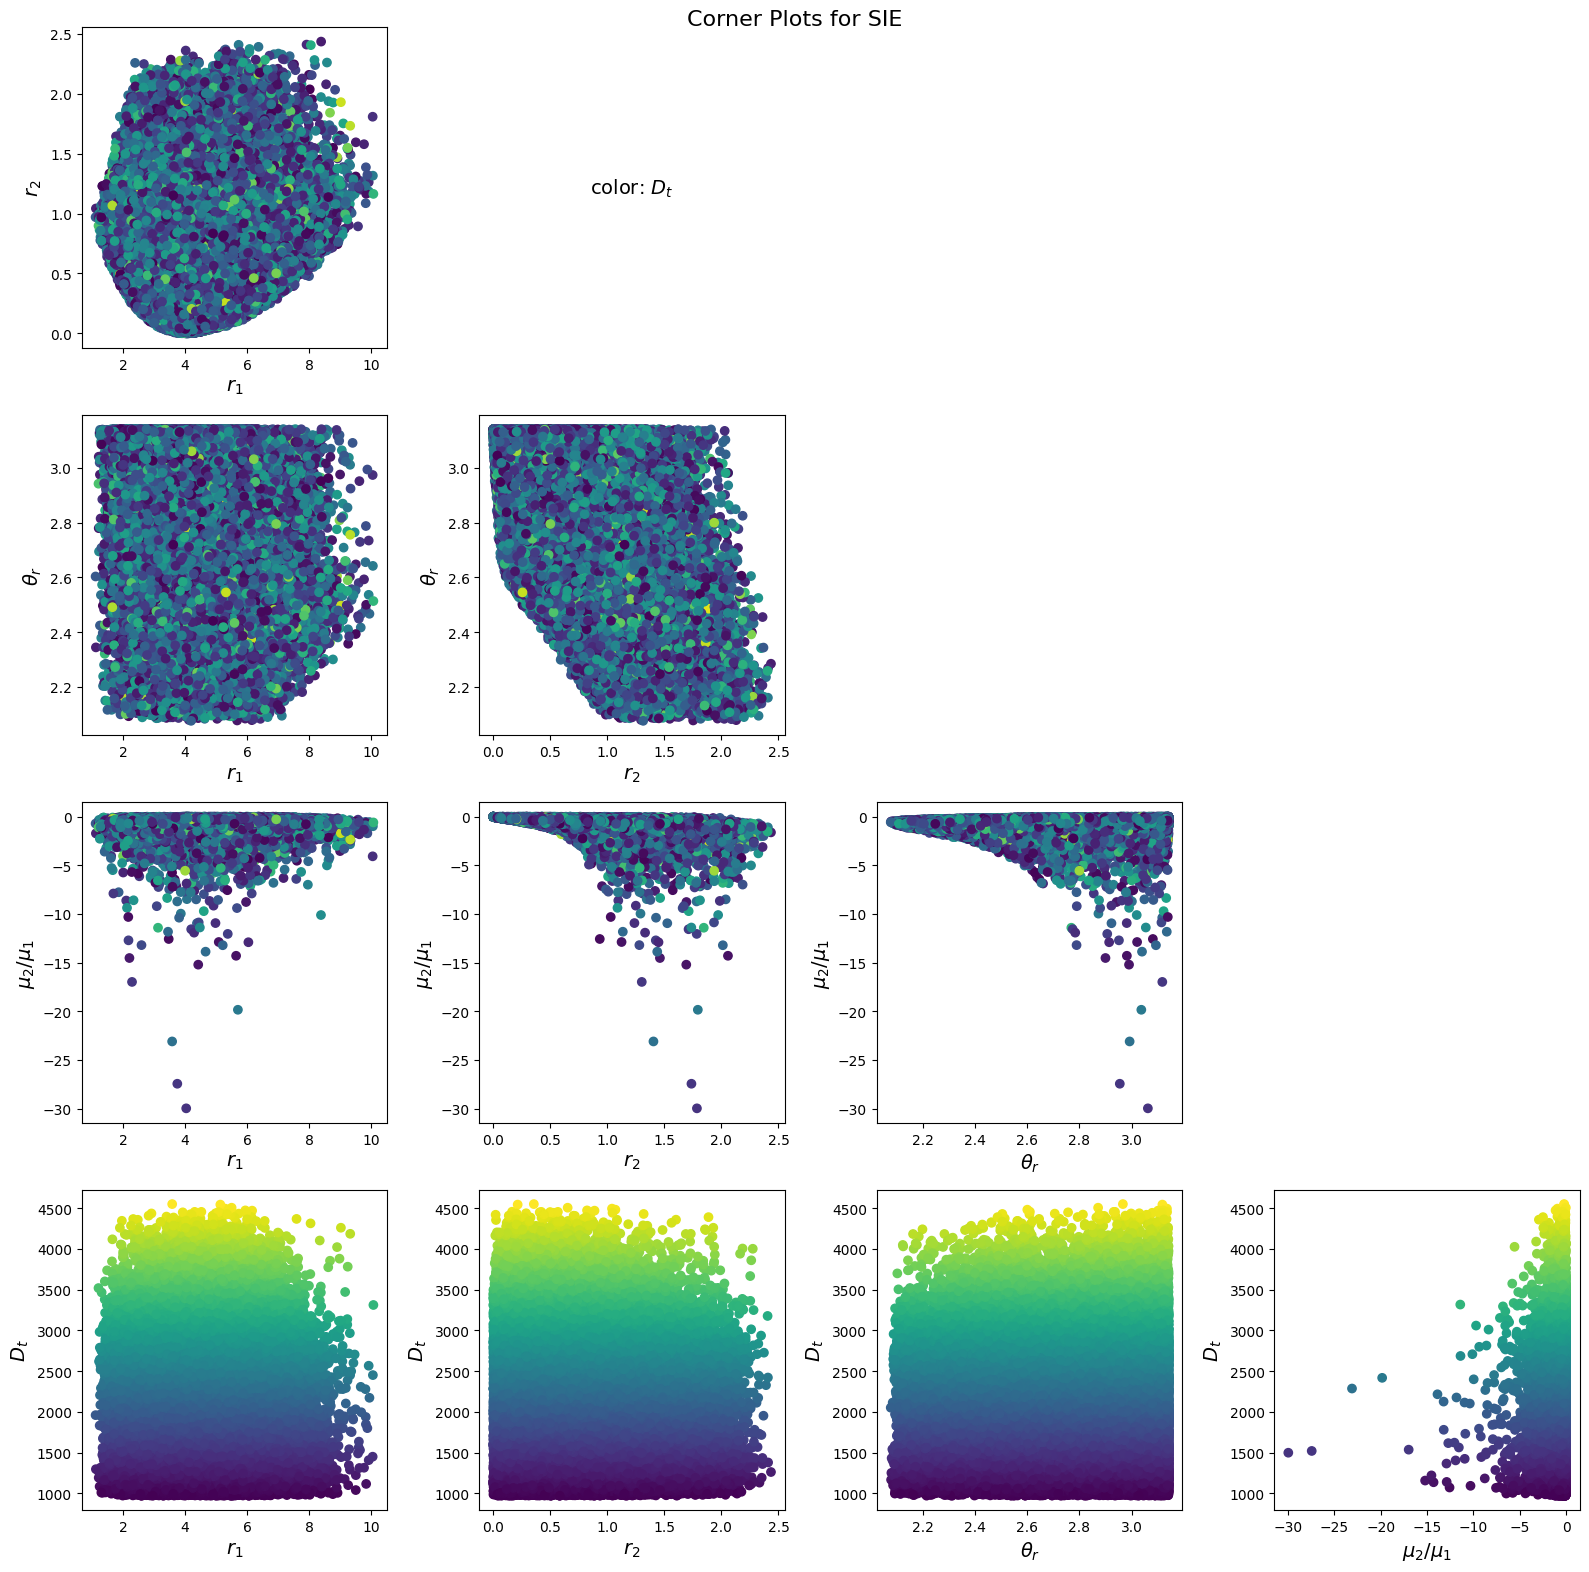

In [22]:
r_1 = [];
r_2 = [];

for i in typeLens_ellip["double"]:
    elem = vals_ellip[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_ellip[i]["mu"][0] for i in typeLens_ellip["double"]])
mu_2 = np.array([vals_ellip[i]["mu"][1] for i in typeLens_ellip["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_ellip[i]["time"][0].value for i in typeLens_ellip["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_ellip[i]["time"][1].value for i in typeLens_ellip["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_ellip[i]["zLens"] for i in typeLens_ellip["double"]])
z_s = np.array([vals_ellip[i]["zSrc"] for i in typeLens_ellip["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, D_t)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 4,['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$', r'$D_t$'], 'Corner Plots for SIE')

##### Ellip Only Image Statistics

In [23]:
## Ellip ONLY
### percentage of Singles, Doubles, and Quads 

single_len_ellip = len(typeLens_ellip["single"]);
double_len_ellip = len(typeLens_ellip["double"]);
quad_len_ellip = len(typeLens_ellip["quad"]);
total_len_ellip = single_len_ellip + double_len_ellip + quad_len_ellip

percent_single_ellip = (single_len_ellip/total_len_ellip)*100
percent_double_ellip = (double_len_ellip/total_len_ellip)*100
percent_quad_ellip = (quad_len_ellip/total_len_ellip)*100

print(percent_single_ellip)
print(percent_double_ellip)
print(percent_quad_ellip)
print(total_len_ellip)

5.169618733113179
89.25848093665566
5.571900330231162
99930


In [24]:
# rare cases lenses
filtered_array_ellip = [d for d in weirdCase_ellip if d!= {}]
rare_case_len_ellip = len(filtered_array_ellip)
total_len_with_rare_ellip = total_len_ellip + rare_case_len_ellip

percent_single_accounting_rare_ellip = (single_len_ellip/total_len_with_rare_ellip)*100
percent_double_accounting_rare_ellip = (double_len_ellip/total_len_with_rare_ellip)*100
percent_quad_accounting_rare_ellip = (quad_len_ellip/total_len_with_rare_ellip)*100
percent_rare_accounting_rare_ellip = (rare_case_len_ellip/total_len_with_rare_ellip)*100

print("The percentage for Single Lenses: ", percent_single_accounting_rare_ellip, "%")
print("The percentage for Double Lenses: ", percent_double_accounting_rare_ellip, "%")
print("The percentage for Quad Lenses: ", percent_quad_accounting_rare_ellip, "%")
print("The percentage for 'Rare' Lenses: ", percent_rare_accounting_rare_ellip, "%")

The percentage for Single Lenses:  5.1659999999999995 %
The percentage for Double Lenses:  89.196 %
The percentage for Quad Lenses:  5.568 %
The percentage for 'Rare' Lenses:  0.06999999999999999 %


In [25]:
### Confirming math:
total_percent_ellip = percent_single_accounting_rare_ellip + percent_double_accounting_rare_ellip + percent_quad_accounting_rare_ellip + percent_rare_accounting_rare_ellip
print(total_percent_ellip)

99.99999999999999


### Ellipticity & Shear

In [26]:
vals_both = np.load(data_path / 'valBoth.npy', allow_pickle = True)

In [44]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_both)):
    print('Here is the image array: \n', vals_both[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_both[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_both[i]["time"], '\n')
    ---
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase_both = []
for i in range(len(vals_both)):
    size = len(vals_both[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase_both.append(neither)

typeLens_both = dict(single = single, double = double, quad = quad)

print("The index array (containing the first 20 elements only) for a single image producing mock lens is: ", typeLens_both["single"][:20],'\n')
print("The index array (containing the first 20 elements only) for a double image producing mock lens is: ", typeLens_both["double"][:20],'\n')
print("The index array (containing the first 20 elements only) for a quad image producing mock lens is: ", typeLens_both["quad"][:20],'\n')

# truncating output:
max_prints = 5
count = 0

for j in weirdCase_both:
    sz = len(j)
    if sz != 0 and count < max_prints:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')
        
        count += 1
print('Output Truncated')
        
        
        

The index array (containing the first 20 elements only) for a single image producing mock lens is:  [2, 8, 12, 13, 14, 60, 66, 84, 96, 108, 114, 122, 156, 174, 179, 186, 208, 245, 261, 264] 

The index array (containing the first 20 elements only) for a double image producing mock lens is:  [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27] 

The index array (containing the first 20 elements only) for a quad image producing mock lens is:  [23, 24, 57, 65, 73, 81, 145, 146, 163, 192, 224, 228, 234, 308, 311, 313, 323, 333, 357, 366] 

The index for neither single, double, or quad is:  19 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------
The index for neither single, double, or quad is:  227 

And the images produced by this lens are:  3 

----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------
The index for neither single, dou

#### Visualizing Shear+Ellipticity Data

Text(0.5, 1.0, 'Graph of Image Positions (SIE+shear)')

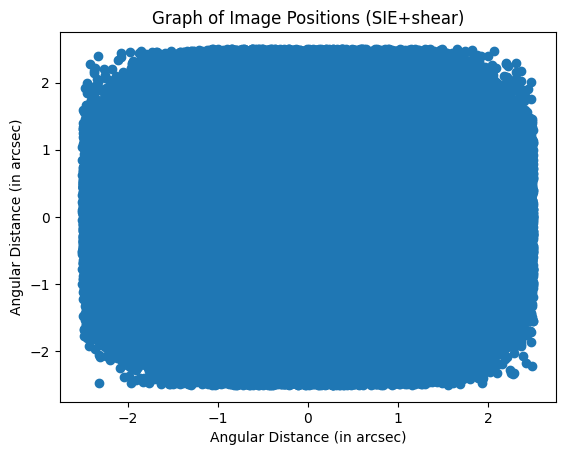

In [28]:
imX_both = [];
imY_both = [];

for i in typeLens_both["single"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imY_both.append(elem[0][1])

for i in typeLens_both["double"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imX_both.append(elem[1][0])
    imY_both.append(elem[0][1])
    imY_both.append(elem[1][1])
    
for i in typeLens_both["quad"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imX_both.append(elem[1][0])
    imX_both.append(elem[2][0])
    imX_both.append(elem[3][0])
    
    imY_both.append(elem[0][1])
    imY_both.append(elem[1][1])
    imY_both.append(elem[2][1])
    imY_both.append(elem[3][1])

newX_both = np.array(imX_both)
newY_both = np.array(imY_both)

plt.scatter(newX_both, newY_both)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIE+shear)')


Text(0.5, 1.0, 'Graph of Source Positions (SIE+shear)')

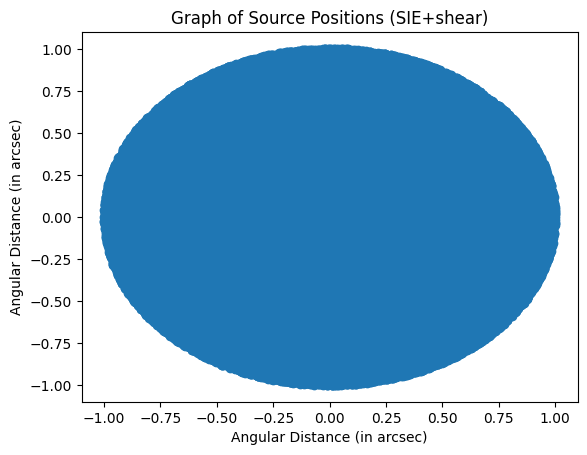

In [29]:
betaOne_both = [vals_both[i]["betaOne"] for i in range(len(vals_both))]
betaTwo_both = [vals_both[i]["betaTwo"] for i in range(len(vals_both))]
plt.scatter(betaOne_both,betaTwo_both)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIE+shear)')

#### Corner Plots for SIE+shear

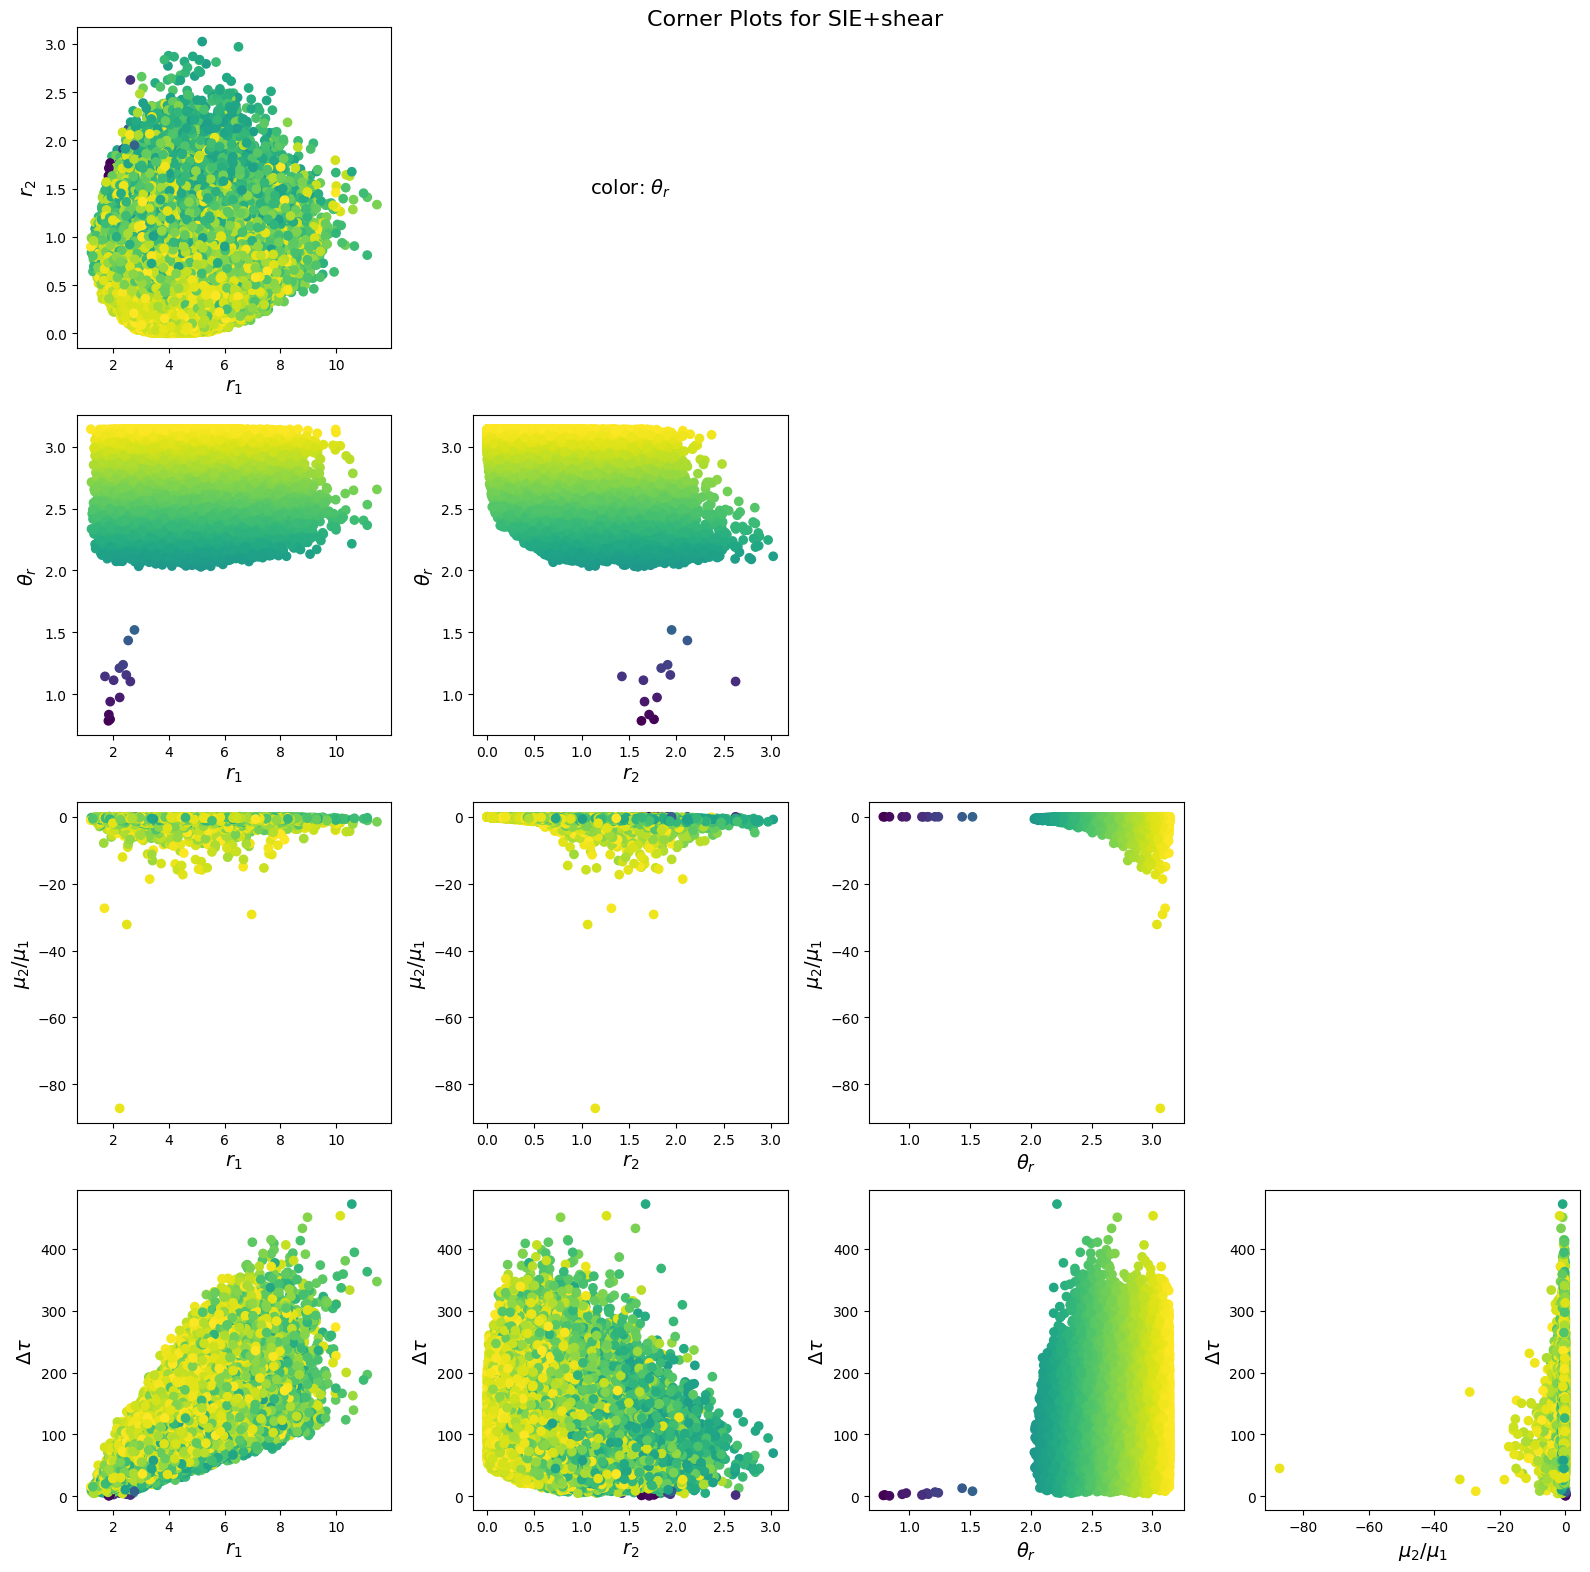

In [30]:
r_1 = [];
r_2 = [];

for i in typeLens_both["double"]:
    elem = vals_both[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_both[i]["mu"][0] for i in typeLens_both["double"]])
mu_2 = np.array([vals_both[i]["mu"][1] for i in typeLens_both["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_both[i]["time"][0].value for i in typeLens_both["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_both[i]["time"][1].value for i in typeLens_both["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_ellip[i]["zLens"] for i in typeLens_ellip["double"]])
z_s = np.array([vals_ellip[i]["zSrc"] for i in typeLens_ellip["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, tau)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 2, ['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$',r'$\Delta\tau$'], 'Corner Plots for SIE+shear') 

##### Shear + Ellip Image Statistics

In [31]:
## Both ONLY
### percentage of Singles, Doubles, and Quads 

single_len_both = len(typeLens_both["single"]);
double_len_both = len(typeLens_both["double"]);
quad_len_both = len(typeLens_both["quad"]);
total_len_both = single_len_both + double_len_both + quad_len_both

percent_single_both = (single_len_both/total_len_both)*100
percent_double_both = (double_len_both/total_len_both)*100
percent_quad_both = (quad_len_both/total_len_both)*100

print(percent_single_both)
print(percent_double_both)
print(percent_quad_both)
print(total_len_both)

6.344762535496754
87.06162136126915
6.593616103234093
99657


In [32]:
# rare cases lenses
filtered_array_both = [d for d in weirdCase_both if d!= {}]
rare_case_len_both = len(filtered_array_both)
total_len_with_rare_both = total_len_both + rare_case_len_both

percent_single_accounting_rare_both = (single_len_both/total_len_with_rare_both)*100
percent_double_accounting_rare_both = (double_len_both/total_len_with_rare_both)*100
percent_quad_accounting_rare_both = (quad_len_both/total_len_with_rare_both)*100
percent_rare_accounting_rare_both = (rare_case_len_both/total_len_with_rare_both)*100

print("The percentage for Single Lenses: ", percent_single_accounting_rare_both, "%")
print("The percentage for Double Lenses: ", percent_double_accounting_rare_both, "%")
print("The percentage for Quad Lenses: ", percent_quad_accounting_rare_both, "%")
print("The percentage for 'Rare' Lenses: ", percent_rare_accounting_rare_both, "%")

The percentage for Single Lenses:  6.3229999999999995 %
The percentage for Double Lenses:  86.763 %
The percentage for Quad Lenses:  6.571000000000001 %
The percentage for 'Rare' Lenses:  0.34299999999999997 %


In [33]:
### Confirming math:
total_percent_both = percent_single_accounting_rare_both + percent_double_accounting_rare_both + percent_quad_accounting_rare_both + percent_rare_accounting_rare_both
print(total_percent)

100.0
